In [1]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision.transforms as T

from torch.utils.data import DataLoader, ConcatDataset
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

In [2]:
IMAGE_DIR = "data"
image_size = 99
batch_size = 16
normalization_stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # Convert channels from [0, 1] to [-1, 1]

In [3]:
normal_dataset = ImageFolder(IMAGE_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*normalization_stats)
]))

# Augment the dataset with mirrored images
mirror_dataset = ImageFolder(IMAGE_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.RandomHorizontalFlip(p=1.0),
    T.ToTensor(),
    T.Normalize(*normalization_stats)
]))

# Augment the dataset with color changes
color_jitter_dataset = ImageFolder(IMAGE_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ColorJitter(0.5, 0.5, 0.5),
    T.ToTensor(),
    T.Normalize(*normalization_stats)
]))

# Combine the datasets
# dataset_list = [normal_dataset, mirror_dataset, color_jitter_dataset]
# dataset = ConcatDataset(dataset_list)

dataset = normal_dataset
dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=4, pin_memory=False)

In [4]:
def denorm(image):
    return image * normalization_stats[1][0] + normalization_stats[0][0]

In [5]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    
def show_batch(dataloader, nmax=64):
    for images, _ in dataloader:
        show_images(images, nmax)
        break

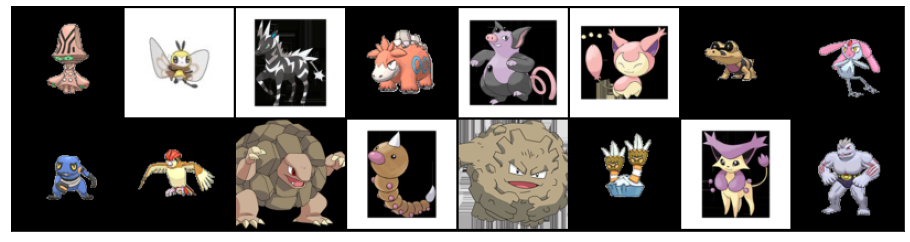

In [6]:
show_batch(dataloader)